# Task 9 (Nonparametric) – Iterative model learning and planning

Nonparametric dynamics (locally weighted average) à la Atkeson & Schaal (1997): collect rollouts, refit a local model, and plan open-loop sequences via random shooting using the learned model.

In [1]:
import os
import sys
from pathlib import Path

current = Path.cwd()
if (current / 'notebooks').exists():
    PROJECT_ROOT = current
else:
    PROJECT_ROOT = current.parent
os.chdir(PROJECT_ROOT)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)

Project root: /home/acepeax/Desktop/Studies/MVA/Robotics/Project


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import casadi as ca
from tqdm import tqdm

from scripts.task_7_env import Task7PendulumEnv, Y_MAX

pybullet build time: Dec  4 2025 20:11:42


In [3]:
# Hyperparameters and helpers
SIM_SUBSTEPS = 6
BASE_DT = 1.0 / 240.0
STEP_DT = BASE_DT * SIM_SUBSTEPS
GRAVITY = 9.81
HORIZON_STEPS = 160
N_SHOOT = 200
SIGMA = 0.6  # kernel width for LWA

print('dt:', STEP_DT)

def make_env(gui=False):
    return Task7PendulumEnv(
        max_steps=HORIZON_STEPS + 50,
        should_balance=False,
        gui=gui,
        sim_substeps=SIM_SUBSTEPS,
        continuous_actions=True,
        verbose=False,
    )

def wrap_to_pi(x):
    return (x + np.pi) % (2*np.pi) - np.pi
INITIAL_RANDOM = 60


dt: 0.025


In [4]:
def to_continuous_angle(theta_array):
    theta_array = np.asarray(theta_array, dtype=float)
    return np.unwrap(theta_array)


In [5]:
DEMO_FILE = Path('data/swing_up_demo.npz')

def load_demo(file_path=DEMO_FILE):
    data = np.load(file_path)
    obs = np.asarray(data['observations'], dtype=float)
    acts = np.asarray(data['actions'], dtype=float).reshape(len(obs), -1)
    states = np.stack([obs[:,0], obs[:,1], obs[:,9], obs[:,12]], axis=1)
    next_states = np.vstack([states[1:], states[-1:]])
    # use recorded actions; if absent, assume zero
    if acts.shape[1] >= 1:
        actions = acts[:,0]
    else:
        actions = np.zeros(len(states))
    return states, actions, next_states


In [6]:
class LocalWeightedDeltaModel:
    def __init__(self, sigma=0.6):
        self.sigma2 = sigma**2
        self.inputs = None
        self.deltas = None
        self.cas_inputs = None
        self.cas_deltas = None

    def fit(self, states, actions, next_states):
        s = np.asarray(states, dtype=float)
        a = np.asarray(actions, dtype=float).reshape(len(states), -1)
        sn = np.asarray(next_states, dtype=float)
        self.inputs = np.hstack([s, a])  # shape (N,5)
        self.deltas = sn - s             # shape (N,4)
        self.cas_inputs = ca.DM(self.inputs)
        self.cas_deltas = ca.DM(self.deltas)

    def predict(self, state, action):
        if self.inputs is None or len(self.inputs) == 0:
            raise RuntimeError('Model not fitted')
        x = np.hstack([state, np.atleast_1d(action)])
        diff = self.inputs - x
        w = np.exp(-np.sum(diff*diff, axis=1) / (2*self.sigma2))
        if np.sum(w) < 1e-8:
            w = np.ones_like(w)
        w = w / np.sum(w)
        delta = w @ self.deltas
        return state + delta

    def predict_casadi(self, state_sym, action_sym):
        if self.cas_inputs is None:
            raise RuntimeError('Model not fitted')
        x = ca.vertcat(state_sym, ca.reshape(action_sym, 1, 1))  # 5x1
        x_rep = ca.repmat(ca.transpose(x), self.cas_inputs.size1(), 1)  # (N,5)
        diff = self.cas_inputs - x_rep
        sq_norm = ca.sum2(diff*diff)  # (N,1) row-wise norm
        w = ca.exp(-sq_norm / (2*self.sigma2))
        w = w / (ca.sum1(w) + 1e-12)
        delta = ca.transpose(w) @ self.cas_deltas  # 1x4
        delta = ca.transpose(delta)  # 4x1
        return state_sym + delta


In [7]:
def collect_rollout(env, policy_fn, horizon):
    obs, _ = env.reset()
    states = []
    actions = []
    next_states = []
    rewards = []
    for t in range(horizon):
        state = np.array([obs[0], obs[1], obs[9], obs[12]], dtype=float)
        action = float(np.clip(policy_fn(state, t), -1.0, 1.0))
        obs_next, reward, terminated, _, info = env.step([[action]])
        next_state = np.array([obs_next[0], obs_next[1], obs_next[9], obs_next[12]], dtype=float)
        states.append(state)
        actions.append(action)
        next_states.append(next_state)
        rewards.append(reward)
        obs = obs_next
        if terminated:
            break
    return np.array(states), np.array(actions), np.array(next_states), np.array(rewards)


In [8]:
def random_shooting_plan(model, start_state, horizon=HORIZON_STEPS, n_candidates=N_SHOOT):
    best_cost = np.inf
    best_u = None
    for _ in range(n_candidates):
        u_seq = np.random.uniform(-1.0, 1.0, size=horizon)
        s = start_state.copy()
        cost = 0.0
        for u in u_seq:
            s = model.predict(s, u)
            theta, theta_dot, y, y_dot = s
            cost += theta*theta + 0.2*theta_dot*theta_dot + 0.5*y*y + 0.1*y_dot*y_dot + 0.001*u*u
        if cost < best_cost:
            best_cost = cost
            best_u = u_seq
    return best_u


In [9]:
# Initial data collection from demo
try:
    states, actions, next_states = load_demo()
    print('Loaded demo with', len(states), 'steps')
except FileNotFoundError:
    print('Demo not found, falling back to random rollout')
    env = make_env(gui=False)
    def random_policy(state, t):
        return np.random.uniform(-1.0, 1.0)
    states, actions, next_states, rewards = collect_rollout(env, random_policy, INITIAL_RANDOM)
    env.close()
    print('Random dataset size:', len(states))

model = LocalWeightedDeltaModel(sigma=SIGMA)
model.fit(states, actions, next_states)
print('Initial dataset size:', len(states))


Loaded demo with 86 steps
Initial dataset size: 86


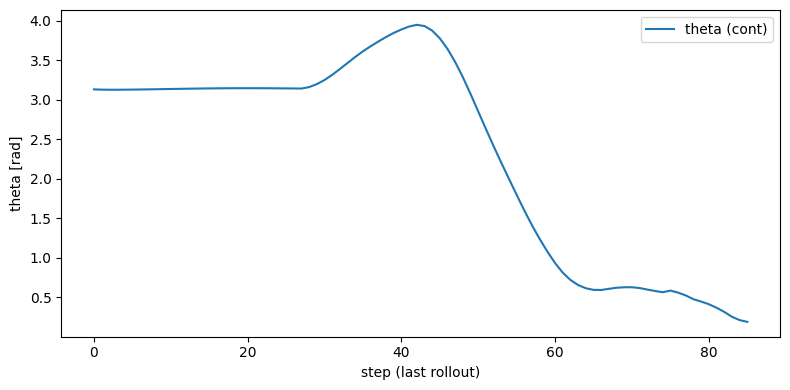

In [10]:
# Inspect last rollout theta (unwrapped)
cont_theta = to_continuous_angle(states[-HORIZON_STEPS:,0])
plt.figure(figsize=(8,4))
plt.plot(cont_theta, label='theta (cont)')
plt.xlabel('step (last rollout)')
plt.ylabel('theta [rad]')
plt.legend()
plt.tight_layout()
plt.show()


In [11]:
# Model-based planning with CasADi using the learned nonparametric dynamics
def plan_with_model(model, start_state, horizon=HORIZON_STEPS, u_limits=(-1.0, 1.0), terminal_weight=10.0):
    opti = ca.Opti()
    X = opti.variable(4, horizon + 1)
    U = opti.variable(1, horizon)
    opti.subject_to(X[:, 0] == start_state.reshape(-1,1))
    opti.set_initial(X[:, 0], start_state.reshape(-1,1))
    cost = 0
    for k in range(horizon):
        s = X[:, k]
        u = U[0, k]
        s_next_pred = model.predict_casadi(s, u)
        opti.subject_to(X[:, k+1] == s_next_pred)
        theta, theta_dot, y, y_dot = s_next_pred[0], s_next_pred[1], s_next_pred[2], s_next_pred[3]
        cost += theta*theta + 0.2*theta_dot*theta_dot + 0.5*y*y + 0.1*y_dot*y_dot + 0.001*u*u
        opti.subject_to(opti.bounded(u_limits[0], u, u_limits[1]))
    theta_T = X[0, -1]
    theta_dot_T = X[1, -1]
    cost += terminal_weight*theta_T*theta_T + 2.0*theta_dot_T*theta_dot_T
    opti.minimize(cost)
    opti.solver('ipopt', {'ipopt.print_level':0, 'print_time':False})
    try:
        sol = opti.solve()
        u_seq = np.array(sol.value(U[0, :])).flatten()
        X_debug = opti.debug.value(X)
        U_debug = opti.debug.value(U)
        return u_seq, X_debug, U_debug
    except Exception as exc:
        X_debug = opti.debug.value(X)
        U_debug = opti.debug.value(U)
        return None, X_debug, U_debug


In [12]:
def try_plan(model, start_state, horizon):
    u_seq, X_dbg, U_dbg = plan_with_model(model, start_state, horizon=horizon, terminal_weight=10.0)
    if X_dbg is not None and U_dbg is not None:
        fig, ax = plt.subplots(2,1, figsize=(8,6))
        prefix_str = ""
        if u_seq is None:
            prefix_str = " (Failed)"
        ax[0].plot(X_dbg[0,:], label='theta')
        ax[0].plot(X_dbg[1,:], label='theta_dot')
        ax[0].legend(); ax[0].set_title('Debug X'+prefix_str)
        ax[1].plot(U_dbg.flatten(), label='u')
        ax[1].legend(); ax[1].set_title('Debug U'+prefix_str)
        plt.tight_layout(); plt.show()
    if u_seq is not None:
        return u_seq
    return U_dbg


argv[0]=--minLoggingLevel=3
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = --minLoggingLevel=3
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
GL_VERSION=4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.24.04.1
Vendor = Intel
Renderer = Mesa Intel(R) Iris(R) Xe Graphics (RPL-U)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaroun

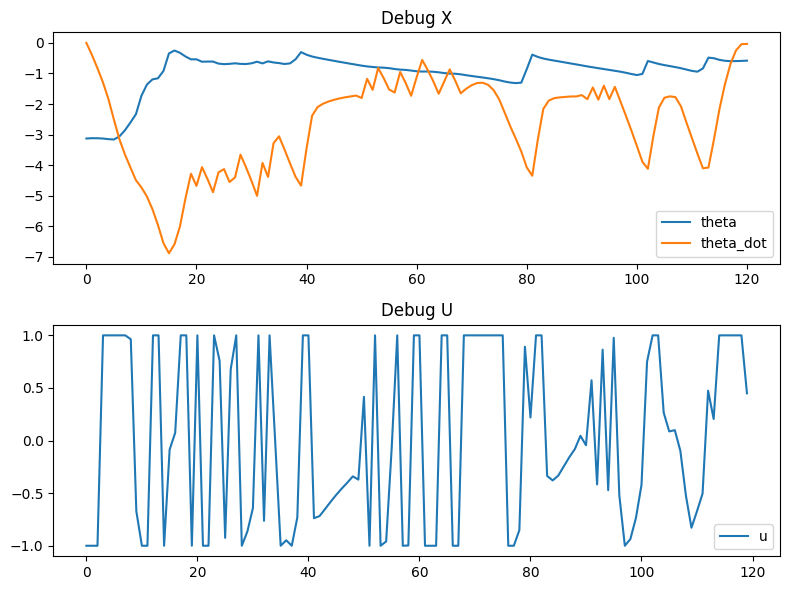

Plan 1: length=120
Iter 1: collected 120 new steps, total data=446
s0:  [3.11296225 0.         0.         0.        ]


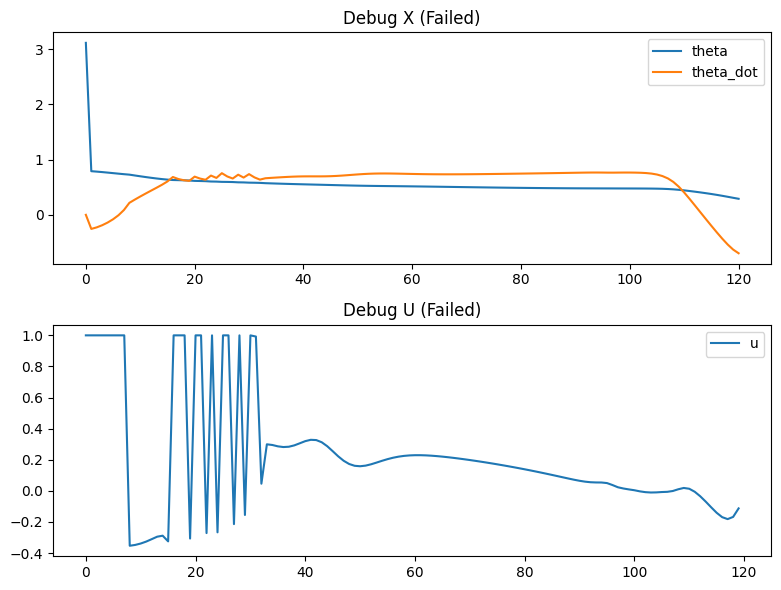

Plan 2: length=120
Iter 2: collected 120 new steps, total data=566
s0:  [-3.11201191  0.          0.          0.        ]


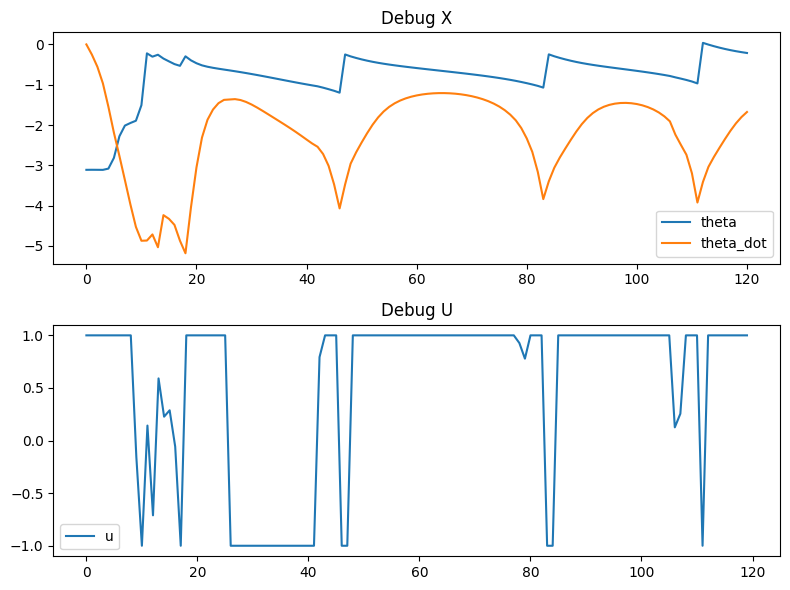

Plan 3: length=120
Iter 3: collected 120 new steps, total data=686
s0:  [-3.13063669  0.          0.          0.        ]


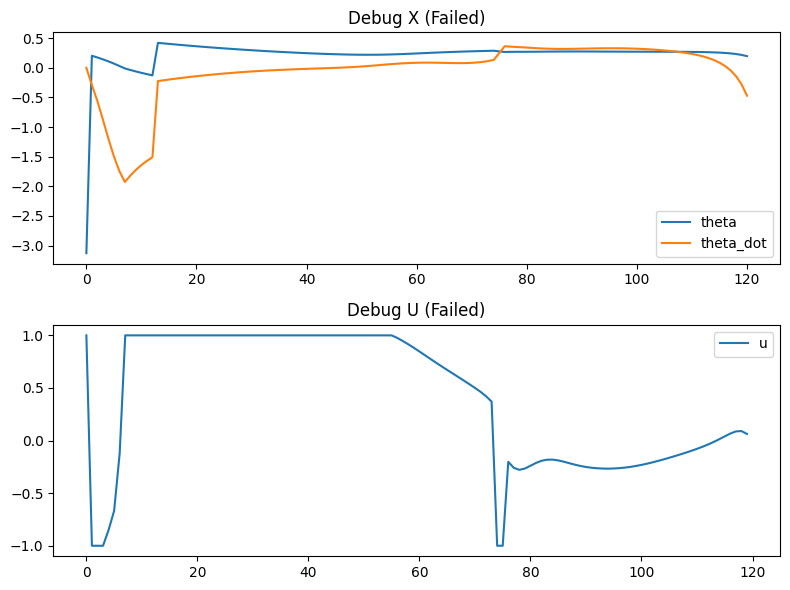

Plan 4: length=120
Iter 4: collected 120 new steps, total data=806
s0:  [3.12457228 0.         0.         0.        ]


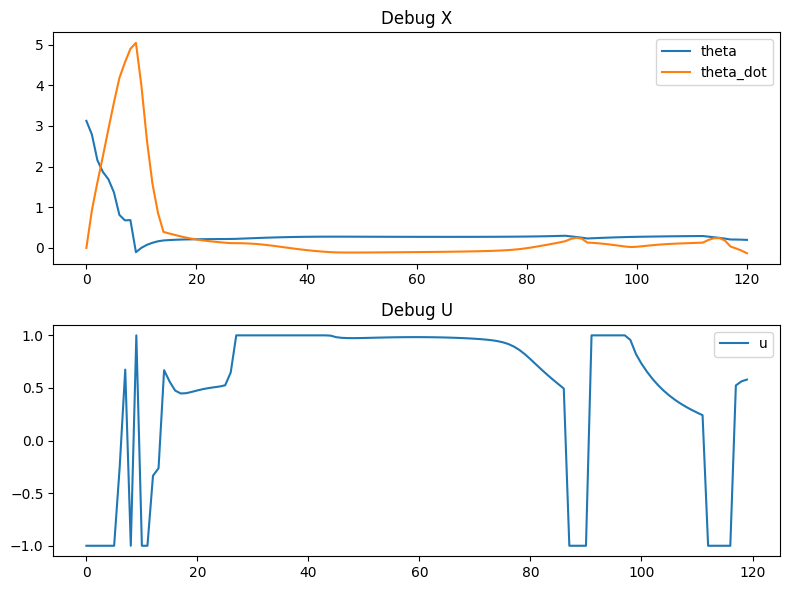

Plan 5: length=120
Iter 5: collected 120 new steps, total data=926
s0:  [-3.12075782  0.          0.          0.        ]


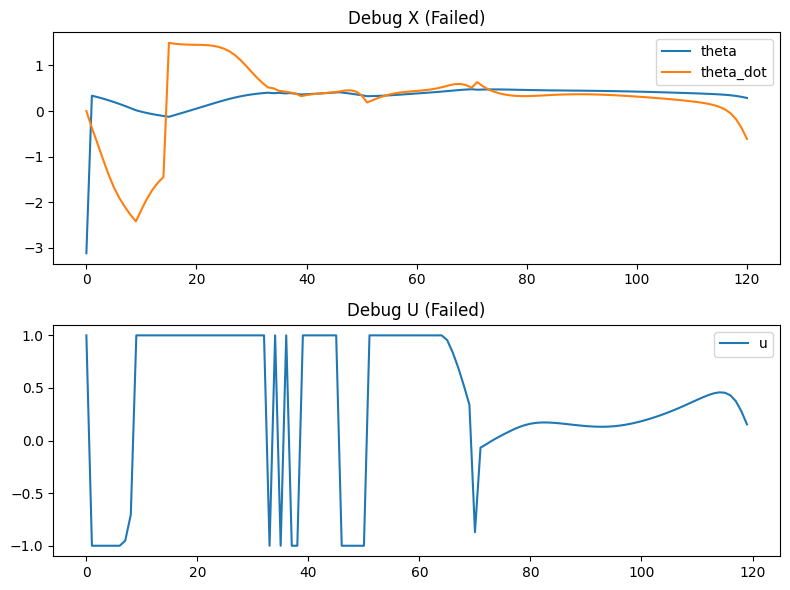

Plan 6: length=120
Iter 6: collected 120 new steps, total data=1046
s0:  [-3.13715696  0.          0.          0.        ]


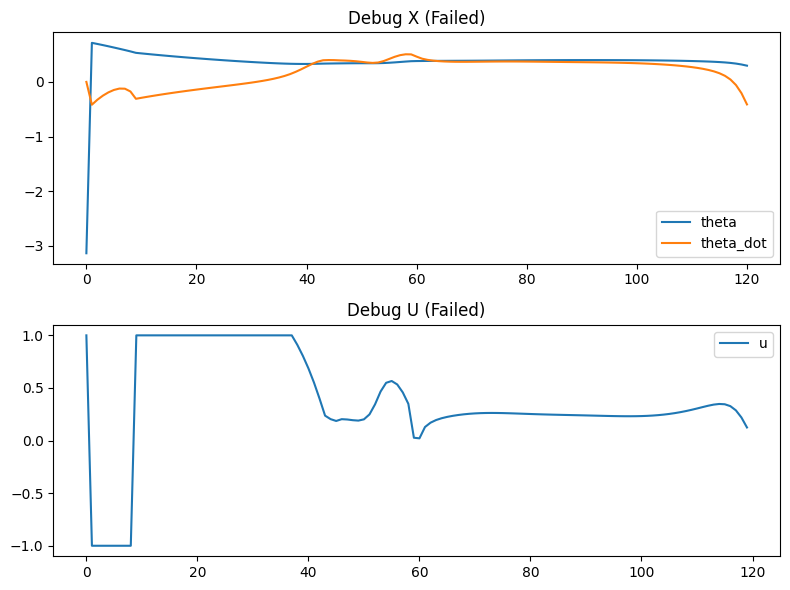

Plan 7: length=120
Iter 7: collected 120 new steps, total data=1166
s0:  [-3.12424564  0.          0.          0.        ]


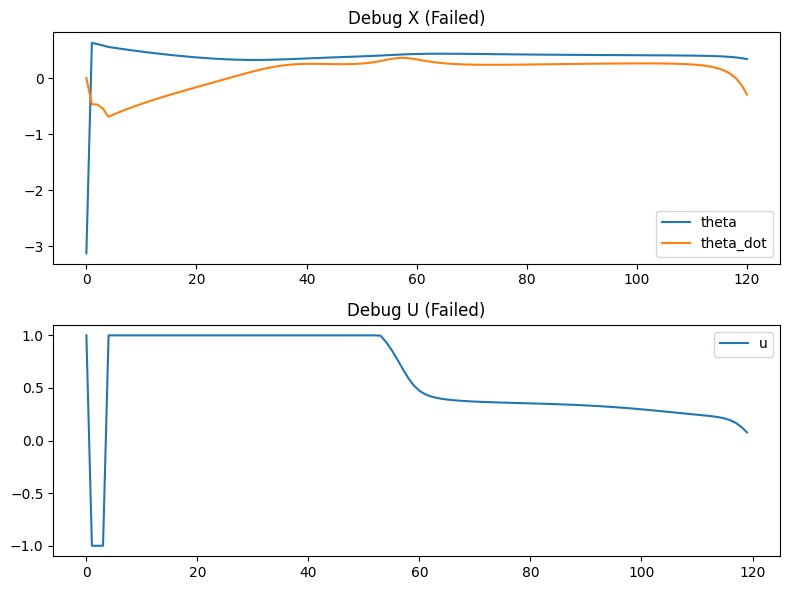

Plan 8: length=120
Iter 8: collected 120 new steps, total data=1286
s0:  [-3.11846614  0.          0.          0.        ]


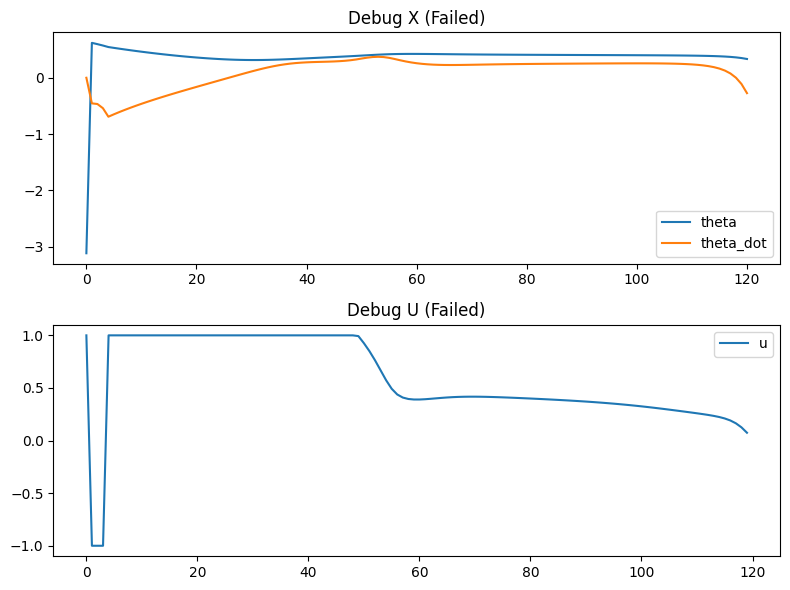

Plan 9: length=120
Iter 9: collected 120 new steps, total data=1406
s0:  [3.11692405 0.         0.         0.        ]


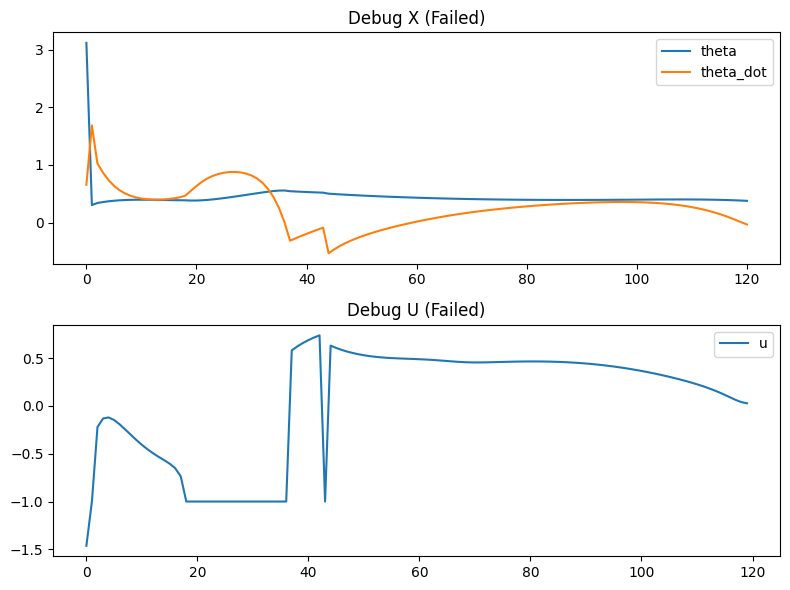

Plan 10: length=120
Iter 10: collected 120 new steps, total data=1526
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed
finished
numActiveThreads = 0
btShutDownExampleBrowser stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


In [14]:
# Planning-execution-refit loop
N_PLAN_ITERS = 10
PLAN_HORIZON = 120
env = make_env(gui=True)
print('Planning loop iterations:', N_PLAN_ITERS)

for it in range(1, N_PLAN_ITERS+1):
    obs, _ = env.reset()
    s0 = np.array([obs[0], obs[1], obs[9], obs[12]], dtype=float)
    print("s0: ",s0)
    u_seq = try_plan(model, s0, PLAN_HORIZON)
    print(f'Plan {it}: length={len(u_seq)}')
    traj_states = []
    traj_actions = []
    traj_next = []
    for u in u_seq:
        obs_next, reward, terminated, _, info = env.step([[u]])
        s = np.array([obs[0], obs[1], obs[9], obs[12]], dtype=float)
        sn = np.array([obs_next[0], obs_next[1], obs_next[9], obs_next[12]], dtype=float)
        traj_states.append(s)
        traj_actions.append(u)
        traj_next.append(sn)
        obs = obs_next
        if terminated:
            break
    states = np.vstack([states, traj_states])
    actions = np.concatenate([actions, traj_actions])
    next_states = np.vstack([next_states, traj_next])
    model.fit(states, actions, next_states)
    print(f'Iter {it}: collected {len(traj_actions)} new steps, total data={len(states)}')

env.close()
